In [1]:
import os
from itertools import product
import config
import json
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
get_model_name = lambda dataset, model_type, curriculum: os.path.join(dataset + ("_" + model_type) + "_" + curriculum.split(".")[0])
import util

In [2]:
get_model_name = lambda dataset, model_type, curriculum: os.path.join(dataset + ("_" + model_type) + "_" + curriculum.split(".")[0])

jobs =[(get_model_name(dataset, model_type, curriculum), dataset, model_type, curriculum) for dataset, model_type, curriculum in product(config.datasets, config.model_types, config.baseline_curricula)]
jobs.extend([(get_model_name(dataset, model_type, model_type + curriculum), dataset, model_type, model_type + curriculum) for dataset, model_type, curriculum  in (product(config.datasets, config.model_types, config.influence_curricula))])
# jobs.extend([(model_name, "external", model_type, "external") for model_name, model_type in config.baseline_models])
print("len jobs", len(jobs))
def get_df(model, dataset, model_type, curriculum):

    blimp_out_path = f"./eval/blimp/{os.path.basename(model)}/blimp_results.json"



    df = None
    try:
        with open(blimp_out_path) as f:
            d = json.load(f)

    except:
        print("skipping", blimp_out_path, "not found")
        return None

    df = pd.DataFrame(d["results"]).T

    df.index.name="metric"
    df = df.drop("alias", axis=1)
    df.columns = [col.replace(',none', '').replace("acc_stderr", "std") for col in df.columns]
    df = df.loc[~df.index.isin(["blimp_supplement", "blimp_filtered"]),:]
    df[["model", "dataset", "model_type", "curriculum"]] = model, dataset, model_type, curriculum
    return df

df = pd.concat((get_df(*job) for job in jobs))
df

len jobs 78
skipping ./eval/blimp/babylm_2024_10m_curriculum_roberta_source_difficulty/blimp_results.json not found
skipping ./eval/blimp/stratified_equitoken_10m_curriculum_roberta_mattr_increasing/blimp_results.json not found
skipping ./eval/blimp/stratified_equitoken_10m_curriculum_roberta_perplexity_increasing/blimp_results.json not found
skipping ./eval/blimp/stratified_10m_curriculum_roberta_source_difficulty/blimp_results.json not found
skipping ./eval/blimp/stratified_10m_curriculum_roberta_mattr_increasing/blimp_results.json not found
skipping ./eval/blimp/stratified_10m_curriculum_roberta_roberta_influence_epoch_repetition/blimp_results.json not found
skipping ./eval/blimp/stratified_10m_curriculum_roberta_roberta_influence_incr_bins_dirac/blimp_results.json not found
skipping ./eval/blimp/stratified_10m_curriculum_roberta_roberta_influence_decr_bins_dirac/blimp_results.json not found
skipping ./eval/blimp/stratified_10m_curriculum_roberta_roberta_influence_incr_bins_lognorm/

,acc,std,model,dataset,model_type,curriculum
metric,,,,,,
blimp_supplement_hypernym,0.488124,0.017237,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt
blimp_supplement_qa_congruence_easy,0.59375,0.061877,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt
blimp_supplement_qa_congruence_tricky,0.315152,0.036277,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt
blimp_supplement_subject_aux_inversion,0.625291,0.007785,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt
blimp_supplement_turn_taking,0.471429,0.029885,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt
...,...,...,...,...,...,...
blimp_wh_questions_subject_gap_long_distance_filtered,0.78063,0.014144,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt
blimp_wh_vs_that_no_gap_filtered,0.888502,0.010733,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt
blimp_wh_vs_that_no_gap_long_distance_filtered,0.898286,0.010225,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt


/tmp/ipykernel_3093493/2427532659.py:63: UserWarning: The palette list has more values (25) than needed (4), which may not be intended.
  sns.violinplot(data=group_data,
/tmp/ipykernel_3093493/2427532659.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha="right")
/tmp/ipykernel_3093493/2427532659.py:63: UserWarning: The palette list has more values (21) than needed (9), which may not be intended.
  sns.violinplot(data=group_data,
/tmp/ipykernel_3093493/2427532659.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha="right")
/tmp/ipykernel_3093493/2427532659.py:63: UserWarning: The palette list has more values (25) than needed (4), which may not be intended.
  sns.violinplot(data=group_data,
/tmp/ipykernel_3093493/242

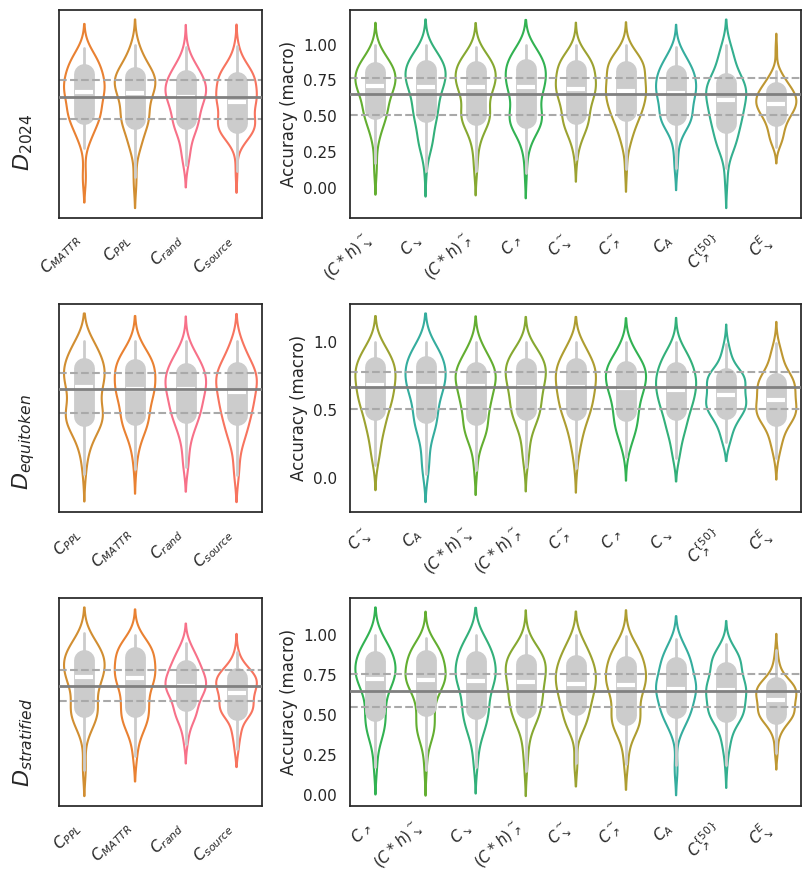

/tmp/ipykernel_3093493/2427532659.py:63: UserWarning: The palette list has more values (25) than needed (3), which may not be intended.
  sns.violinplot(data=group_data,
/tmp/ipykernel_3093493/2427532659.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha="right")
/tmp/ipykernel_3093493/2427532659.py:63: UserWarning: The palette list has more values (21) than needed (9), which may not be intended.
  sns.violinplot(data=group_data,
/tmp/ipykernel_3093493/2427532659.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha="right")
/tmp/ipykernel_3093493/2427532659.py:63: UserWarning: The palette list has more values (25) than needed (2), which may not be intended.
  sns.violinplot(data=group_data,
/tmp/ipykernel_3093493/242

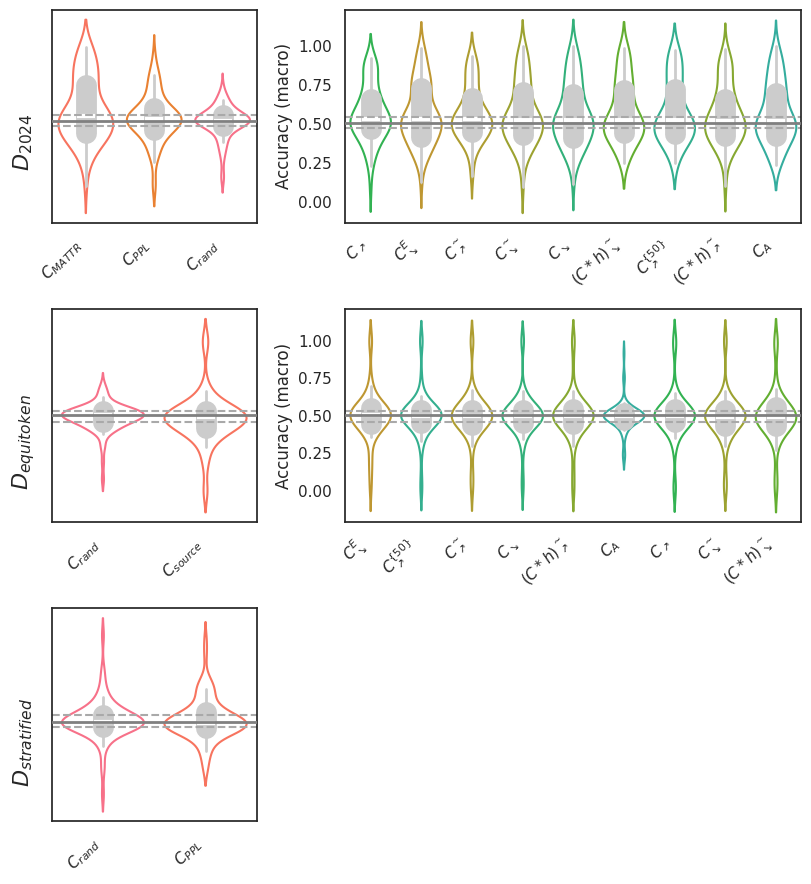

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import numpy as np
for model_type in config.model_types:
        
        df["plot_group"] = df["curriculum"].str.contains("influence")
        WIDTH_TWO_COL = 8.04

        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

        n_rows = len(config.datasets) 
        n_cols = 2 
        fig = plt.figure(figsize=(WIDTH_TWO_COL, 3 * n_rows))

        gs = GridSpec(n_rows, 2, figure=fig, width_ratios=[0.45, 1]) 


        all_plotted_models = set()

        temp_df = df[df["model"].str.contains("|".join(config.datasets))] 
        for baseline_dataset in config.datasets:
                model_data_pre = temp_df[temp_df["model"].str.contains(baseline_dataset)]
                for plot_group in model_data_pre["plot_group"].unique():
                        group_data_pre = model_data_pre[model_data_pre["plot_group"] == plot_group]
                        
                        model_medians_index = group_data_pre.groupby("model")["acc"].median().sort_values(ascending=False).index
                        all_plotted_models.update(model_medians_index)

        unique_model_list = sorted(list(all_plotted_models))
        num_unique_models = len(df[df["dataset"] ==df["dataset"].unique()[0]]["model"].unique())
        global_palette = sns.color_palette("husl", n_colors=num_unique_models)




        n_baseline_curricula = len(df[df["plot_group"] == False]["curriculum"].unique())
        axes = [[None for _ in range(n_cols)] for _ in range(n_rows)] 


        for i, baseline_dataset in enumerate(config.datasets):
 
                model_data = df[(df["model"].str.contains(baseline_dataset) & (df["model_type"] == model_type)) | (df["model"].str.contains("gpt") if model_type =="roberta" else df["model"].str.contains("baby-llama"))]
            
                
                col_idx = 0
                plot_groups_in_data = model_data["plot_group"].unique()

                for is_baseline_half in plot_groups_in_data:

                        axes[i][col_idx] = fig.add_subplot(gs[i, col_idx])
                        ax = axes[i][col_idx]

                        
                        group_data = model_data[model_data["plot_group"] == is_baseline_half]

                        
                        model_medians = group_data.groupby("model")["acc"].median().sort_values(ascending=False).index


                        sns.violinplot(data=group_data,
                                        x="model", y="acc",
                                        ax=ax,
                                        hue="curriculum",
                                        fill=False,             
                                        palette=global_palette[n_baseline_curricula:] if is_baseline_half else global_palette, 
                                        order=model_medians,
                                        inner_kws=dict(box_width=15, whis_width=2, color=".8"),
                                        legend=False           
                                        )

                        # Custom X-tick label formatting
                        current_xticklabels = ax.get_xticklabels()
                        new_xticklabels = [util.rename_model(label.get_text()) for label in current_xticklabels]
                        ax.set_xticklabels(new_xticklabels, rotation=45, ha="right")

                
                        random_model_name = f"{baseline_dataset}_{model_type}_random"
                        if random_model_name in df["model"].unique():
                                random_acc = df[df["model"] == random_model_name]["acc"]
                                if not random_acc.empty:
                                        ax.axhline(random_acc.median(), ls='-', zorder=10, linewidth=2, color="gray")
                                        ax.axhline(random_acc.quantile(0.25), ls='--', color="darkgrey") 
                                        ax.axhline(random_acc.quantile(0.75), ls='--', color="darkgrey") 

                        
                        if ax.get_legend() is not None:
                                ax.get_legend().remove()

                        ax.set_title("") 
                        ax.set_xlabel("")


                        if not is_baseline_half:
                                ax.set_ylabel("")
                                ax.set_yticks([])

                        else:
                                ax.set_ylabel("")
                                ax.set_ylabel("Accuracy (macro)")



                        col_idx += 1 

        
                fig.text(0.01, (n_rows - 1 - i + 0.5) / n_rows,
                        util.rename_dataset(baseline_dataset),
                        ha="center",
                        va="center",
                        fontsize=16,
                        rotation=90,
                        fontweight="heavy")


        plt.tight_layout() 

        util.save_pdf(fig, "violin_plots_"+model_type)
        plt.show()

In [4]:
def get_random_baseline(x):
    x = os.path.basename(x)
    dataset = None
    for d in config.datasets:
        if os.path.basename(d) in x:
            dataset = d
    model_type = None
    for m in config.model_types:

        if os.path.basename(m) in x:
            model_type = m
    if dataset is None or model_type is None:
        return "external"    
    else:
        return df[df["model"].str.contains(os.path.basename(dataset)+"_"+os.path.basename(model_type)+"_random")]["model"].iloc[0]
 


In [5]:
get_random_baseline("loris3/stratified_10m_curriculum_llama_mattr_increasing")

'loris3/stratified_10m_curriculum_llama_random'

In [6]:
def get_model_type(x):
    if "roberta" in x: 
        return "RoBERTa"
    if "llama" in x :
        return "Llama"
    if "gpt-bert" in x:
        return "gpt-bert"
    print("f", x)

In [7]:
import pandas as pd
from scipy import stats
import numpy as np
models = df["model"].unique()


results = []

for model in models:
    random_acc = pd.to_numeric(df[df["model"] == get_random_baseline(model)]["acc"])
    model_acc = pd.to_numeric(df[df["model"] == model]["acc"])
    print(get_random_baseline(model))
    t_stat, p_val = np.nan, np.nan
    if "external" not in get_random_baseline(model):
        t_stat, p_val = stats.ttest_rel(model_acc, random_acc,alternative="two-sided")

       
    avg_improvement = (model_acc - random_acc).mean() *100
    results.append((model, model_acc.mean(), random_acc.mean() if not "rand" in model else "-", p_val, avg_improvement if not "external" in model else "-", p_val < 0.05 ))

results_df = pd.DataFrame(results, columns=["model","model_acc", "random_acc","p_value","average_improvement", "significant"])

table = results_df.sort_values(by="average_improvement")
def format_with_significance(row):
    
    val = f"{row['average_improvement']:+.2f}\%"
    if row['p_value'] < 0.01:
        val += "***"
    elif row['p_value'] < 0.05:
        val += "**"
    elif row['p_value'] < 0.1:
        val += "*"

    return val if "nan" not in val else "-"


table["formatted_improvement"] = table.apply(format_with_significance, axis=1)
table["dataset"] = table["model"].apply(lambda x: util.rename_dataset(util.get_dataset(x)))
table["curriculum"] = table["model"].apply(lambda x: util.rename(util.get_curriculum_name(x)))
table["model_type"] = table["model"].apply(get_model_type)
table["model"] = table["model"].apply(util.rename_model)




baseline = table[table["curriculum"].isin(["external", "$C_{rand}$"])].sort_values(by="model_acc")
others = table[~table["curriculum"].isin(["external", "$C_{rand}$"])]


ordered_table = pd.concat([baseline, others])



result = ordered_table[["model", "dataset", "model_type", "formatted_improvement", "p_value", "model_acc", "random_acc"]]

result = result.rename(columns={
    "formatted_improvement" : "Improvement",
    "model" : "Curriculum",
    "dataset" : "Dataset",
    "model_type": "Architecture",
    "p_value" : "p-val",
    "model_acc" : "Model acc",
    "random_acc" : "Random acc"
    })
display(result)
result = result.fillna("-")
latex_code = result.to_latex(index=False, escape=False,float_format="%.3f",multirow=False)
latex_lines = latex_code.split("\n")


last_baseline_idx = len(baseline) 


line_to_insert_after = last_baseline_idx + 4 


latex_lines.insert(line_to_insert_after, "\\hline \\hline")

latex_code_with_double_line = "\n".join(latex_lines)
print(latex_code_with_double_line)


loris3/babylm_2024_10m_curriculum_llama_random
loris3/babylm_2024_10m_curriculum_llama_random
loris3/babylm_2024_10m_curriculum_llama_random
loris3/babylm_2024_10m_curriculum_llama_random
loris3/babylm_2024_10m_curriculum_roberta_random
loris3/babylm_2024_10m_curriculum_roberta_random
loris3/babylm_2024_10m_curriculum_roberta_random
loris3/stratified_equitoken_10m_curriculum_llama_random
loris3/stratified_equitoken_10m_curriculum_llama_random
loris3/stratified_equitoken_10m_curriculum_llama_random
loris3/stratified_equitoken_10m_curriculum_llama_random
loris3/stratified_equitoken_10m_curriculum_roberta_random
loris3/stratified_equitoken_10m_curriculum_roberta_random
loris3/stratified_10m_curriculum_llama_random
loris3/stratified_10m_curriculum_llama_random
loris3/stratified_10m_curriculum_llama_random
loris3/stratified_10m_curriculum_llama_random
loris3/stratified_10m_curriculum_roberta_random
loris3/stratified_10m_curriculum_roberta_random
loris3/babylm_2024_10m_curriculum_llama_rando

,Curriculum,Dataset,Architecture,Improvement,p-val,Model acc,Random acc
11,$C_{rand}$,$D_{equitoken}$,RoBERTa,+0.00\%,NaN,0.490155,-
4,$C_{rand}$,$D_{2024}$,RoBERTa,+0.00\%,NaN,0.496967,-
17,$C_{rand}$,$D_{stratified}$,RoBERTa,+0.00\%,NaN,0.516892,-
7,$C_{rand}$,$D_{equitoken}$,Llama,+0.00\%,NaN,0.630457,-
0,$C_{rand}$,$D_{2024}$,Llama,+0.00\%,NaN,0.631135,-
...,...,...,...,...,...,...,...
30,$C^{\sim}_{\searrow}$,$D_{2024}$,RoBERTa,+6.56\%**,0.015163,0.562579,0.496967
36,$C_{A}$,$D_{2024}$,RoBERTa,+6.98\%**,0.010176,0.566731,0.496967
5,$C_{MATTR}$,$D_{2024}$,RoBERTa,+7.33\%***,0.007654,0.570238,0.496967
35,$C^{\{50\}}_{\nearrow}$,$D_{2024}$,RoBERTa,+7.71\%***,0.004998,0.574034,0.496967


\begin{tabular}{lllllrl}
\toprule
Curriculum & Dataset & Architecture & Improvement & p-val & Model acc & Random acc \\
\midrule
$C_{rand}$ & $D_{equitoken}$ & RoBERTa & +0.00\% & - & 0.490 & - \\
$C_{rand}$ & $D_{2024}$ & RoBERTa & +0.00\% & - & 0.497 & - \\
$C_{rand}$ & $D_{stratified}$ & RoBERTa & +0.00\% & - & 0.517 & - \\
$C_{rand}$ & $D_{equitoken}$ & Llama & +0.00\% & - & 0.630 & - \\
$C_{rand}$ & $D_{2024}$ & Llama & +0.00\% & - & 0.631 & - \\
$C_{rand}$ & $D_{stratified}$ & Llama & +0.00\% & - & 0.645 & - \\
\hline \hline
$C^E_{\searrow}$ & $D_{stratified}$ & Llama & -5.84\%*** & 0.000 & 0.587 & 0.645 \\
$C^E_{\searrow}$ & $D_{equitoken}$ & Llama & -5.62\%*** & 0.000 & 0.574 & 0.630 \\
$C_{source}$ & $D_{stratified}$ & Llama & -5.57\%*** & 0.000 & 0.589 & 0.645 \\
$C^E_{\searrow}$ & $D_{2024}$ & Llama & -5.16\%*** & 0.000 & 0.580 & 0.631 \\
$C^{\{50\}}_{\nearrow}$ & $D_{2024}$ & Llama & -3.66\%*** & 0.010 & 0.595 & 0.631 \\
$C^{\{50\}}_{\nearrow}$ & $D_{equitoken}$ & Llama & -

In [8]:
55365

55365

In [9]:
table.to_pickle("./benchmark_results.pkl")

In [10]:
out = pd.DataFrame(table.groupby("curriculum")["average_improvement"].mean().sort_values()).rename(columns={
    "average_improvement" : "Improvement",
    "model" : "Curriculum",
    "dataset" : "Dataset",
    "model_type": "Architecture",
    "p_value" : "p-val",
    "model_acc" : "Model acc",
    "random_acc" : "Random acc"
    }).to_latex(index=True, escape=False,float_format="%.3f",multirow=False)
print(out)

\begin{tabular}{lr}
\toprule
 & Improvement \\
curriculum &  \\
\midrule
$C_{source}$ & -2.186 \\
$C^E_{\searrow}$ & -1.858 \\
$C_{rand}$ & 0.000 \\
$C^{\{50\}}_{\nearrow}$ & 0.394 \\
$C_{PPL}$ & 1.590 \\
$C_{A}$ & 2.216 \\
$C^{\sim}_{\nearrow}$ & 2.513 \\
$(C*h)^{\sim}_{\nearrow}$ & 2.724 \\
$C^{\sim}_{\searrow}$ & 2.739 \\
$C_{\searrow}$ & 2.779 \\
$(C*h)^{\sim}_{\searrow}$ & 3.080 \\
$C_\nearrow$ & 3.145 \\
$C_{MATTR}$ & 3.447 \\
\bottomrule
\end{tabular}



In [11]:
out = pd.DataFrame(table.groupby(["model_type","curriculum"])["average_improvement"].mean().sort_values()).reset_index().rename(columns={
    "average_improvement" : "Improvement",
    "model" : "Curriculum",
    "dataset" : "Dataset",
    "model_type": "Architecture",
    "p_value" : "p-val",
    "model_acc" : "Model acc",
    "model_type" : "Type",
    "random_acc" : "Random acc"
    }).to_latex(index=False, escape=False,float_format="%.3f",multirow=False)
print(out)

\begin{tabular}{llr}
\toprule
Type & curriculum & Improvement \\
\midrule
Llama & $C^E_{\searrow}$ & -5.541 \\
Llama & $C_{source}$ & -2.564 \\
Llama & $C^{\{50\}}_{\nearrow}$ & -2.296 \\
RoBERTa & $C_{source}$ & -1.050 \\
RoBERTa & $C_{rand}$ & 0.000 \\
Llama & $C_{rand}$ & 0.000 \\
Llama & $C_{A}$ & 1.179 \\
RoBERTa & $C_{PPL}$ & 1.561 \\
Llama & $C_{PPL}$ & 1.609 \\
Llama & $C^{\sim}_{\nearrow}$ & 1.918 \\
Llama & $C_{MATTR}$ & 2.153 \\
Llama & $C_{\searrow}$ & 2.196 \\
Llama & $(C*h)^{\sim}_{\searrow}$ & 2.289 \\
Llama & $(C*h)^{\sim}_{\nearrow}$ & 2.350 \\
Llama & $C^{\sim}_{\searrow}$ & 2.505 \\
Llama & $C_\nearrow$ & 2.681 \\
RoBERTa & $C^{\sim}_{\searrow}$ & 3.090 \\
RoBERTa & $(C*h)^{\sim}_{\nearrow}$ & 3.284 \\
RoBERTa & $C^{\sim}_{\nearrow}$ & 3.404 \\
RoBERTa & $C_{\searrow}$ & 3.653 \\
RoBERTa & $C^E_{\searrow}$ & 3.665 \\
RoBERTa & $C_{A}$ & 3.773 \\
RoBERTa & $C_\nearrow$ & 3.841 \\
RoBERTa & $(C*h)^{\sim}_{\searrow}$ & 4.267 \\
RoBERTa & $C^{\{50\}}_{\nearrow}$ & 4.429 

In [12]:
df

,acc,std,model,dataset,model_type,curriculum,plot_group
metric,,,,,,,
blimp_supplement_hypernym,0.488124,0.017237,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_qa_congruence_easy,0.59375,0.061877,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_qa_congruence_tricky,0.315152,0.036277,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_subject_aux_inversion,0.625291,0.007785,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_turn_taking,0.471429,0.029885,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
...,...,...,...,...,...,...,...
blimp_wh_questions_subject_gap_long_distance_filtered,0.78063,0.014144,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True
blimp_wh_vs_that_no_gap_filtered,0.888502,0.010733,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True
blimp_wh_vs_that_no_gap_long_distance_filtered,0.898286,0.010225,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True


In [14]:
df

,acc,std,model,dataset,model_type,curriculum,plot_group
metric,,,,,,,
blimp_supplement_hypernym,0.488124,0.017237,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_qa_congruence_easy,0.59375,0.061877,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_qa_congruence_tricky,0.315152,0.036277,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_subject_aux_inversion,0.625291,0.007785,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_turn_taking,0.471429,0.029885,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
...,...,...,...,...,...,...,...
blimp_wh_questions_subject_gap_long_distance_filtered,0.78063,0.014144,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True
blimp_wh_vs_that_no_gap_filtered,0.888502,0.010733,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True
blimp_wh_vs_that_no_gap_long_distance_filtered,0.898286,0.010225,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True


In [15]:
df

,acc,std,model,dataset,model_type,curriculum,plot_group
metric,,,,,,,
blimp_supplement_hypernym,0.488124,0.017237,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_qa_congruence_easy,0.59375,0.061877,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_qa_congruence_tricky,0.315152,0.036277,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_subject_aux_inversion,0.625291,0.007785,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
blimp_supplement_turn_taking,0.471429,0.029885,loris3/babylm_2024_10m_curriculum_llama_random,loris3/babylm_2024_10m_curriculum,llama,random.pt,False
...,...,...,...,...,...,...,...
blimp_wh_questions_subject_gap_long_distance_filtered,0.78063,0.014144,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True
blimp_wh_vs_that_no_gap_filtered,0.888502,0.010733,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True
blimp_wh_vs_that_no_gap_long_distance_filtered,0.898286,0.010225,loris3/stratified_10m_curriculum_llama_llama_influence_tracin_sandwich,loris3/stratified_10m_curriculum,llama,llama_influence_tracin_sandwich.pt,True


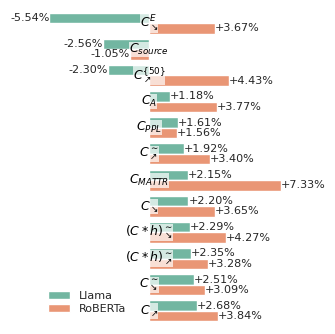

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(figsize=(3.5, 3.5))  # Width = 10 inches, Height = 6 inches

df = pd.DataFrame(table[table["curriculum"] != "$C_{rand}$"].groupby(["model_type","curriculum"])["average_improvement"].mean().sort_values()).reset_index().rename(columns={
    "average_improvement" : "Improvement",
    "curriculum" : "Curriculum",
    "dataset" : "Dataset",
    "model_type": "Architecture",
    "p_value" : "p-val",
    "model_acc" : "Model acc",
    "model_type" : "Type",
    "random_acc" : "Random acc"
})

sns.set_palette("Set2")
ax = sns.barplot(
    data=df,
    x="Improvement",
    y="Curriculum",
    hue="Type",
    
)
curricula = [label.get_text() for label in ax.get_yticklabels()]

for i, curriculum in enumerate(curricula):
    ax.text(0, i, curriculum, ha='center', va='center', fontsize=9, fontweight='bold', color='black', zorder=4,
        bbox=dict(facecolor='white', edgecolor='none',boxstyle=f"square,pad={0}",alpha=0.7 ),
)

ax.bar_label(ax.containers[0], fontsize=8,fmt='%+.2f%%')
ax.bar_label(ax.containers[1], fontsize=8,fmt='%+.2f%%')
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("")
plt.legend(
    frameon=False,       
    facecolor='white',  
    fontsize=8,         
    loc='lower left',   
    markerscale=0.5,   
    labelspacing=0.3    
)
sns.despine(left=True, right=True, top=True, bottom=True)

plt.tight_layout()
plt.show()
util.save_pdf(fig, "accuracy_delta_per_curriculum")

In [ ]:
import config
data = { # language aquisition: (human-likeness, model-likeness)

"source_difficulty.pt": (5,1),
"mattr_increasing.pt": (4,1),
"perplexity_increasing.pt": (3,2),
"_influence_epoch_repetition.pt": (4,2),
"_influence_decr_cp_dirac.pt": (2,3),
"_influence_decr_bins_lognorm.pt": (3,3),
"_influence_decr_bins_dirac.pt": (3,3),
"_influence_incr_bins_lognorm.pt": (3,3),
"_influence_incr_bins_dirac.pt": (3,3),

"_influence_top_50_cp_shuffled.pt": (3,2),
"_influence_tracin_sandwich.pt": (4,1),

"_influence_incr_cp_dirac.pt": (2,3),
"random.pt": (1,5),


}
for c in config.baseline_curricula:
    if c not in data:
        print(c)

In [ ]:
table.groupby(["curriculum", "model_type"])["average_improvement"].mean().sort_values()

In [ ]:
table.groupby("dataset")["average_improvement"].mean().sort_values()

In [ ]:
table.groupby(["dataset"])["average_improvement"].mean().sort_values()